In [1]:
import logging
import math
import gym
from gym import spaces
import numpy as np
from scipy.integrate import ode
sin = np.sin
cos = np.cos

logger = logging.getLogger(__name__)

class CartPoleEnv(gym.Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second' : 50
    }

    def __init__(self):
        self.g = -9.81 # gravity constant [m/s^2]
        self.m0 = 1.0 # mass of cart [kg]
        self.m1 = 0.5 # mass of bar 1 [kg]
        self.m2 = 0.5 # mass of bar 2 [kg]
        self.L1 = 1 # length of bar 1 [m]
        self.L2 = 1 # length of bar 2 [m]
        self.l1 = self.L1/2 # distance to cg for bar 1 (half the length of bar 1) [m]
        self.l2 = self.L2/2 # distance to cg for bar 2 (half the length of bar 2) [m]
        self.I1 = self.m1*(self.L1^2)/12 # moment of inertia of bar 1 with respect to its cg [kgm^2]
        self.I2 = self.m2*(self.L2^2)/12 # moment of inertia of bar 2 with respect to its cg [kgm^2]
        self.tau = 0.02  # size of time step [s]
        self.counter = 0 #count of time steps
        self.angle = 0.1 #Range of values for angle of bar 1 when resetting the system [rad]
    

        # Thresholds at which the episode fails
        #Original CartPole from OpenAI Gym fails according to angle, in this version
        #angle thresholds is made very big so it never fails because of the angle.
        self.theta_threshold_radians = 100000 * 2 * math.pi / 360
        self.x_threshold = 2.4

        # Angle limit set to 2 * theta_threshold_radians so failing observation is still within bounds
        high = np.array([
            self.x_threshold * 2,
            np.finfo(np.float32).max,
            self.theta_threshold_radians * 2,
            np.finfo(np.float32).max])

        self.reset()
        self.viewer = None

        # Just need to initialize the relevant attributes
        self._configure()

    def _configure(self, display=None):
        self.display = display 

    def step(self, action):
       #state vector is defined as [theta0 theta1 theta2 theta0_dot theta1_dot theta2_dot]
        state = self.state
        theta0 = state.item(0) #position of the cart [m]
        theta1 = state.item(1) #angle of bar 1 [rad]
        theta2 = state.item(2) #angle of bar 2 [rad]
        theta0_dot = state.item(3) #velocity of the cart [m/s]
        theta1_dot = state.item(4) #angular velocity of bar 1 [rad/s]
        theta2_dot = state.item(5) #angular velocity of bar 2 [rad/s]
        u = action #input: force applied to the cart [N]
        self.counter += 1
        
        #This function obtains the ODE for a given state vector and an input
        def func(t, state, u):
            theta0 = state.item(0)
            theta1 = state.item(1)
            theta2 = state.item(2)
            theta0_dot = state.item(3)
            theta1_dot = state.item(4)
            theta2_dot = state.item(5)
            state = np.matrix([[theta0],[theta1],[theta2],[theta0_dot],[theta1_dot],[theta2_dot]]) # this is needed for some weird reason
            
            #Calculate terms for matrices
            a1 = self.m0 + self.m1 + self.m2
            a2 = self.m1*self.l1 + self.m2*self.L1
            a3 = self.m2*self.l2
            a4 = self.m1*(self.l1**2) + self.m2*(self.L1**2) + self.I1
            a5 = self.m2*self.L1*self.l2
            a6 = self.m2*(self.l2**2) + self.I2
            f1 = (self.m1*self.l1 + self.m2*self.L1)*self.g 
            f2 = self.m2*self.l2*self.g    
            
            #A matrix
            A = np.matrix([[a1, a2*cos(theta1), a3*cos(theta2)], 
                    [a2*cos(theta1), a4, a5*cos(theta1-theta2)],
                    [a3*cos(theta2), a5*cos(theta1-theta2), a6]])
            iA = np.linalg.inv(A) #inverse of matrix A 
            
            #C matrix
            C = np.matrix([[0, -a2*sin(theta1)*theta1_dot, -a3*sin(theta2)*theta2_dot],
                    [0, 0, a5*sin(theta1-theta2)*theta2_dot],
                    [0, -a5*sin(theta1-theta2)*theta1_dot, 0]])
            
            #G matrix       
            G = np.matrix([[0], [-f1*sin(theta1)], [-f2*sin(theta2)]])
            
            #H matrix
            H  = np.matrix([[1],[0],[0]])
            
            #Identity and zero matrices 
            I = np.matrix([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
            O_3_3 = np.matrix([[0, 0, 0], [0, 0, 0], [0, 0, 0]])
            O_3_1 = np.matrix([[0], [0], [0]])
            
            #calculate ODE
            matrix1 = np.bmat([[O_3_3, I],[O_3_3, -iA*C]])
            matrix2 = np.bmat([[O_3_1],[iA*G]])
            matrix3 = np.bmat([[O_3_1],[iA*H]])
            state_dot = matrix1*state +matrix2 + matrix3*u 
            return state_dot
        
        #Apply Runge-Kutta routine to solve ODE, thus obtain the state for next time step
        solver = ode(func) 
        solver.set_integrator("dop853") # (Runge-Kutta)
        solver.set_f_params(u)
        t0 = 0
        state0 = state
        solver.set_initial_value(state0, t0)
        solver.integrate(self.tau)
        state=solver.y
        
        self.state = state
        
        #Boolean variable to determine whether an episode is finished or not
        done =  theta0 < -self.x_threshold \
                or theta0 > self.x_threshold \
                or self.counter > 1000 \
                or theta1 > 90*2*np.pi/360 \
                or theta1 < -90*2*np.pi/360 
        done = bool(done)

        #Define reward accordint to cost function
        reward = -(1/self.counter)*(200*normalize_angle(theta1) + 200*normalize_angle(theta2))

        return self.state, reward, done, {}

    #Function to set initial conditions at the beginning of each episode
    #All values are zero except for theta1
    def reset(self):
        self.state = np.matrix([[0],[np.random.uniform(-self.angle,self.angle)],[0],[0],[0],[0]])
        self.counter = 0
        return self.state
    
    #Function for animation of the cartpole
    def render(self, mode='human', close=False):
        if close:
            if self.viewer is not None:
                self.viewer.close()
                self.viewer = None
            return

        screen_width = 600
        screen_height = 400

        world_width = self.x_threshold*2
        scale = screen_width/world_width
        carty = 150 # TOP OF CART
        polewidth = 10.0
        polelen = scale * self.L1
        cartwidth = 50.0
        cartheight = 30.0

        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(screen_width, screen_height, display=self.display)
            l,r,t,b = -cartwidth/2, cartwidth/2, cartheight/2, -cartheight/2
            axleoffset =cartheight/4.0
            cart = rendering.FilledPolygon([(l,b), (l,t), (r,t), (r,b)])
            self.carttrans = rendering.Transform()
            cart.add_attr(self.carttrans)
            self.viewer.add_geom(cart)
            l,r,t,b = -polewidth/2,polewidth/2,polelen-polewidth/2,-polewidth/2
            pole = rendering.FilledPolygon([(l,b), (l,t), (r,t), (r,b)])
            pole.set_color(.8,.6,.4)
            self.poletrans = rendering.Transform(translation=(0, axleoffset))
            pole.add_attr(self.poletrans)
            pole.add_attr(self.carttrans)
            self.viewer.add_geom(pole)
            self.axle = rendering.make_circle(polewidth/2)
            self.axle.add_attr(self.poletrans)
            self.axle.add_attr(self.carttrans)
            self.axle.set_color(.5,.5,.8)
            self.viewer.add_geom(self.axle)
            
            l,r,t,b = -polewidth/2,polewidth/2,polelen-polewidth/2,-polewidth/2
            pole2 = rendering.FilledPolygon([(l,b), (l,t), (r,t), (r,b)])
            pole2.set_color(.2,.6,.4)
            self.poletrans2 = rendering.Transform(translation=(0, polelen-5))
            pole2.add_attr(self.poletrans2)
            pole2.add_attr(self.poletrans)
            pole2.add_attr(self.carttrans)
            self.viewer.add_geom(pole2)
            self.axle2 = rendering.make_circle(polewidth/2)
            self.axle2.add_attr(self.poletrans2)
            self.axle2.add_attr(self.poletrans)
            self.axle2.add_attr(self.carttrans)
            self.axle2.set_color(.1,.5,.8)
            self.viewer.add_geom(self.axle2)
            
            self.track = rendering.Line((0,carty), (screen_width,carty))
            self.track.set_color(0,0,0)
            self.viewer.add_geom(self.track)

        state = self.state
        cartx = state.item(0)*scale+screen_width/2.0 # MIDDLE OF CART
        self.carttrans.set_translation(cartx, carty)
        self.poletrans.set_rotation(-state.item(1))
        self.poletrans2.set_rotation(-(state.item(2)-state.item(1)))

        return self.viewer.render(return_rgb_array = mode=='rgb_array')

#Function that converts the angle to a value between 0 and 2*pi   
def normalize_angle(angle):
    normalized_angle = abs(angle)
    normalized_angle = normalized_angle % (2*np.pi)
    if normalized_angle > np.pi:
        normalized_angle = normalized_angle - 2*np.pi
    normalized_angle = abs(normalized_angle)
    return normalized_angle

Run:1 Episode number: 20, mean reward over past 20 episodes is 133.9
Run:1 Episode number: 40, mean reward over past 20 episodes is 123.85
Run:1 Episode number: 60, mean reward over past 20 episodes is 84.75
Run:1 Episode number: 80, mean reward over past 20 episodes is 101.8
In run: 1 passed 94 episodes, solved after 74 trials
Runs that have successfully converged: 1
Run:2 Episode number: 20, mean reward over past 20 episodes is 91.3
Run:2 Episode number: 40, mean reward over past 20 episodes is 173.55
Run:2 Episode number: 60, mean reward over past 20 episodes is 167.5
Run:2 Episode number: 80, mean reward over past 20 episodes is 71.65
Run:2 Episode number: 100, mean reward over past 20 episodes is 76.9
Run:2 Episode number: 120, mean reward over past 20 episodes is 102.55
Run:2 Episode number: 140, mean reward over past 20 episodes is 62.95
Run:2 Episode number: 160, mean reward over past 20 episodes is 100.85
In run: 2 passed 178 episodes, solved after 158 trials
Runs that have su

c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:178: RuntimeWarning: Mean of empty slice


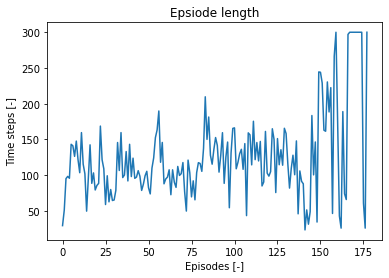

c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:187: RuntimeWarning: Mean of empty slice


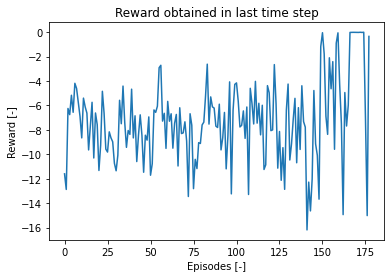

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random

env = CartPoleEnv()


#Function to store weight vector and length of episodes in a text file
def log(log_message):
    
    #Choose location to save the text file
    with open("C:/Users/Dell/Desktop/log_double.txt", "a") as log_file:
        # write the log message to logfile:
        log_file.write(log_message)
        log_file.write("\n")

        #Function that returns converts the angle to a value between 0 and 2*pi 
def normalize_angle(angle):
    normalized_angle = abs(angle)
    normalized_angle = normalized_angle % (2*np.pi)
    if normalized_angle > np.pi:
        normalized_angle = normalized_angle - 2*np.pi
    normalized_angle = abs(normalized_angle)
    return normalized_angle

#Function to create the state-action feature vector x(s,a)
def feature_vector(state, action):
    theta0 = state.item(0)
    theta1 = state.item(1)
    theta2 = state.item(2)
    theta0_dot = state.item(3)
    theta1_dot = state.item(4)
    theta2_dot = state.item(5)
    X = np.array([normalize_angle(theta1)**2, normalize_angle(theta1),normalize_angle(theta2)**2, normalize_angle(theta2), 
            abs(theta1_dot), theta1_dot, abs(theta2_dot), theta2_dot,
            action*theta1, action*theta2, action*theta1_dot, action*theta2_dot])           
    return X

#Function to get the approximate Q-values
def q_hat(state, action, w):
    X = feature_vector(state, action)
    output = np.dot(X,w)
    return output
    
#Epislon-greedy policy to choose action:
def get_action(u,state, w, episode,epsilon):
    actions = [-u, u]
    qs = []
    for action in actions:
        qs.append(q_hat(state, action, w))
    max_index = np.argmax(qs)
    
     #Probability of choosing a random action increases with the number episodes ran
    if random.random() >= min(epsilon, 1 - math.log10((episode + 1) / 25)):
        action = actions[max_index]
    else:
        action = random.choice(actions)
    return action

#Function to choose best action according to both weight vectors according to Epsilon greedy policy
def maxAction(u,state, w_a, w_b, episode, epsilon):
    actions = [-u, u]
    #Sum Q-values from both weight vectors
    values = np.array([q_hat(state,a,w_a) + q_hat(state,a,w_b) for a in actions])
    index = np.argmax(values)
    
    #Probability of choosing random action increases with the number of episodes
    if random.random() >= min(epsilon, 1 - math.log10((episode + 1) / 25)):
        action = actions[index]
    else:
        action = random.choice(actions)
    return action



""""
SET THE NEXT 4 PARAMETERS TO CHANGE HOW LONG THE CODE WILL RUN
"""
runs = 10 #How many times the whole algorithm will be run. Each run will derive in a different learning process.  
total_episodes = 200 #Number of episodes in each run 
tmax = 300 #maximum length of each episode
train = False #Use True to run all training (weight vector starts as zero vector)
             #Use False to see pendulum already working (weight vector starts with solution)
    
#Arrays to store length of epiosdes and rewards
total = np.zeros((runs,total_episodes))
total_r = np.zeros((runs,total_episodes))

convergence = 0 #Counter for number of runs in which convergence happened


for k in range(runs):
    #Hyperparameters
    gamma = 0.99
    alpha =  0.000003
    epsilon = 0
    #Parameters
    force = 40
    env.angle = 0.1
    env.m0 = 1
    env.m1 = 0.5
    env.m2 = 0.5
    env.L1 = 1
    env.L2 = 1
    
    if train == True:
        w_a = np.array([0,0,0,0,0,0,0,0,0,0,0,0])
        w_b = np.array([0,0,0,0,0,0,0,0,0,0,0,0])
    else:
        w_a = np.array([-0.02280849, -0.02167535, -0.01490352, -0.01171898, -0.08545458, 0.01757736, -0.041585, -0.00239529, 0.00187348, -0.0249188, 0.00272126, -0.01347324])
        w_b = np.array([-0.02463546, -0.02337954, -0.01576357, -0.0125458,  -0.0912821, 0.01426613, -0.04317293, -0.00124234, 0.0087355, 0.00093051, -0.00214467,  0.01078374])
    
    #Updates for the weight vectors
    delta_w_a = np.array([0,0,0,0,0,0,0,0,0,0,0,0])
    delta_w_b = np.array([0,0,0,0,0,0,0,0,0,0,0,0])
    

    timesteps = [] #Array to store the length of each episode
    scores = deque(maxlen = 20) #Array to store length of the 20 most recent episodes
    
    for i_episode in range(total_episodes):
        total_reward = 0
        state = env.reset() #initialize system
    
        #Choose first action according to both weight vectors
        action = maxAction(force,state, w_a, w_b, i_episode, epsilon)
        
        for t in range(tmax):
            #Uncomment next line to see the animation
            #env.render()
            action = maxAction(force,state, w_a, w_b, i_episode, epsilon) #choose action
            observation, reward, done, info = env.step(action) #observe next state and reward
            total_reward += reward
            
            #Randomly choose which weight vector to update
            if random.choice([True,False]) == True:
                #Update w_a, but get Q-value of next state according to w_b
                delta_w_a = (alpha*(reward + gamma*q_hat(observation, get_action(force,observation, w_a, i_episode, epsilon), w_b) - q_hat(state, action, w_a)))*feature_vector(state, action)
                w_a = np.add(w_a,delta_w_a)
            else:
                #Update w_b, but get Q-value of next state according to w_a
                delta_w_b = (alpha*(reward + gamma*q_hat(observation, get_action(force,observation, w_b, i_episode, epsilon), w_a) - q_hat(state, action, w_b)))*feature_vector(state, action)
                w_b = np.add(w_b,delta_w_b)
        
            #Save state for next time step
            state = observation
    
            #Store results once the episode finishes
            if done or t+1 >= tmax:
                #Uncomment next line to print results of each episode
                #print("Episode " + str(i_episode) + " finished after " + str(t+1) + " timesteps" + "action: " + str(action) + " reward: "+ str(total_reward))
                timesteps += [t+1]
                scores.append(t+1)
                total[k][i_episode] =  t+1
                total_r[k][i_episode] =  reward
                mean_length = np.mean(scores) #get mean of last 20 episodes
                break
        
        #Set condition to flag convergence
        if mean_length >= 200 and i_episode >= 19:
            print("In run: " + str(k+1) + " passed {} episodes, solved after {} trials".format(i_episode + 1, i_episode + 1 - 20))
            convergence += 1
            print("Runs that have successfully converged: " + str(convergence))
            break
        elif (i_episode + 1) % 20 == 0 and(i_episode + 1) >= 20:
            print("Run:"+ str(k+1)+ " Episode number: {}, mean reward over past 20 episodes is {}".format(i_episode + 1, mean_length))
            
    #Log results in text file
    log(str(k+1) +" "+ str(timesteps))
    log(str(w_a))
    log(str(w_b))
    #plt.show()

#Plot average length of each episode in all runs
total[total == 0] = np.nan
mean_episodes = np.nanmean(total, axis=0)
plt.plot(mean_episodes)
plt.title('Epsiode length')
plt.xlabel('Episodes [-]')
plt.ylabel('Time steps [-]')
plt.show()

#Plot average reward of each episode for all runs
total_r[total_r == 0] = np.nan
mean_r= np.nanmean(total_r, axis=0)
plt.plot(mean_r)
plt.title('Reward obtained in last time step')
plt.xlabel('Episodes [-]')
plt.ylabel('Reward [-]')
plt.show()